<a href="https://colab.research.google.com/github/iliyasalve/NLTK_Spam_Detection/blob/main/source/nltk_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLTK Spam Detection

## Import libraries

In [ ]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Manipulation with data

Connecting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping data into a data folder

In [ ]:
!mkdir data
!unzip '/content/drive/MyDrive/Colab Notebooks/My_Projects/nltk_spam_detector/data/sms+spam+collection.zip' -d data

Archive:  /content/drive/MyDrive/Colab Notebooks/My_Projects/nltk_spam_detector/data/sms+spam+collection.zip
  inflating: data/SMSSpamCollection  
  inflating: data/readme             


Initializing data and displaying it on the screen

In [ ]:
df = pd.read_table("data/SMSSpamCollection" , sep='\t' ,header = None)
df = df.rename(columns={0: 'label', 1: 'text_message'})

In [ ]:
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

In [ ]:
df.head()

,label,text_message
0,spam,"Shop till u Drop, IS IT YOU, either 10K, 5K, £..."
1,ham,Send me yetty's number pls.
2,spam,Thanks for the Vote. Now sing along with the s...
3,ham,Nite...
4,ham,U don't remember that old commercial?


Adding length for each message

In [ ]:
#df['label_num'] = df.label.map({'ham':0, 'spam':1})
df['message_len'] = df.text_message.apply(len)

In [ ]:
df.head()

,label,text_message,message_len
0,spam,"Shop till u Drop, IS IT YOU, either 10K, 5K, £...",156
1,ham,Send me yetty's number pls.,27
2,spam,Thanks for the Vote. Now sing along with the s...,121
3,ham,Nite...,7
4,ham,U don't remember that old commercial?,37


Image of a graph of frequency and length of messages

Text(0.5, 0, 'Message Length')

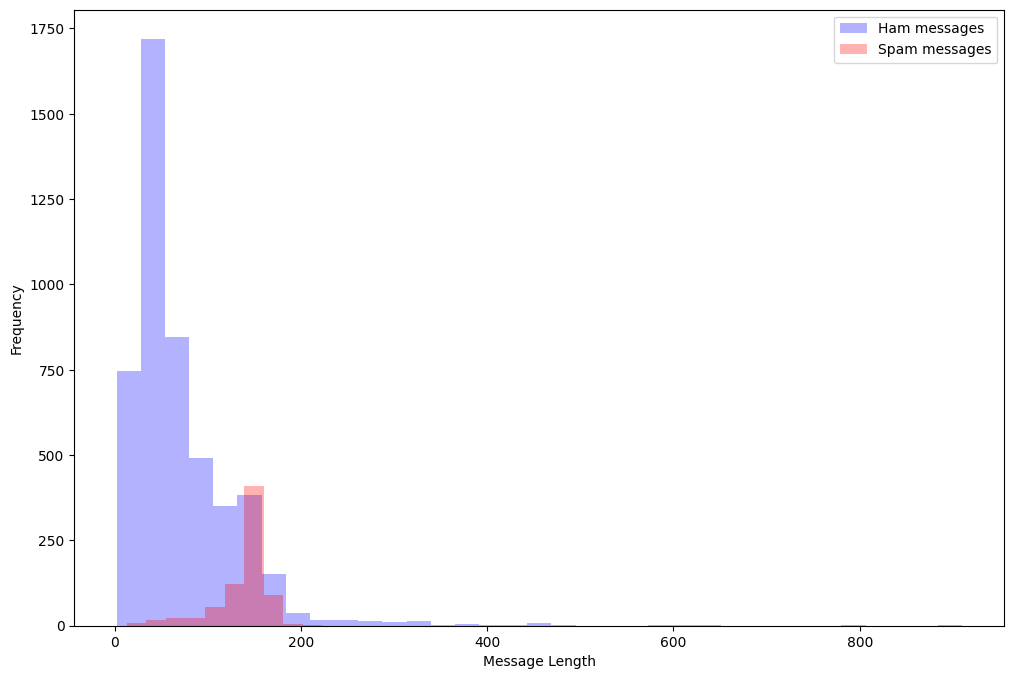

In [ ]:
plt.figure(figsize=(12, 8))

df[df.label=='ham'].message_len.plot(bins = 35, kind = 'hist', color = 'blue', label = 'Ham messages', alpha = 0.3)
df[df.label=='spam'].message_len.plot(kind = 'hist', color = 'red', label = 'Spam messages', alpha = 0.3)

plt.legend()

plt.xlabel("Message Length")

Message statistics

In [ ]:
df[df.label=='ham'].describe()

,message_len
count,4825.000000
mean,71.482487
std,58.440652
min,2.000000
25%,33.000000
50%,52.000000
75%,93.000000
max,910.000000


In [ ]:
df[df.label=='spam'].describe()

,message_len
count,747.000000
mean,138.670683
std,28.873603
min,13.000000
25%,133.000000
50%,149.000000
75%,157.000000
max,223.000000


## Data Pre-processing

 Initialisation the Stemming and Lemmatization

In [ ]:
stemming = PorterStemmer()
lemmatization = WordNetLemmatizer()

Creating a function in which:
- changes message to lowercase;
- removes stopwords;
- lemmatization / stemming the remainder of the sentence.

In [ ]:
def preprocess(message, is_stemming = True):

  message = message.lower()

  words = word_tokenize(message)

  words = [word for word in words if word not in stopwords.words("english")]

  if is_stemming:
    words = [stemming.stem(word) for word in words]
  else:
    words = [lemmatization.lemmatize(word, pos='v') for word in words]

  message = " ".join(words)

  return message

Pre-processing of all messages

In [ ]:
messages_set = []

for index, row in df.iterrows():
    words_filtered = [i for i in preprocess(row['text_message'], is_stemming = False).split() if len(i) >= 3]
    messages_set.append((words_filtered, row['label']))

Show result

In [ ]:
print(messages_set[:2])

[(['shop', 'till', 'drop', 'either', '10k', '£500', 'cash', '£100', 'travel', 'voucher', 'call', '09064011000.', 'ntt', 'box', 'cr01327bt', 'fixedline', 'cost', '150ppm', 'mobile', 'vary'], 'spam'), (['send', 'yetty', 'number', 'pls'], 'ham')]


## Features creation

Creation a single list of all words

In [ ]:
def get_words_in_messages(messages):

  all_words = []

  for message in messages:
    all_words.extend(message[0])

  return all_words

Creation a feature list

In [ ]:
def get_word_features(word_list):

  word_list = nltk.FreqDist(word_list)
  word_features = word_list.keys()

  return word_features

Initialization the word features for the entier dataset

In [ ]:
word_features = get_word_features(get_words_in_messages(messages_set))

Show the word features length

In [ ]:
print(len(word_features))

7994


## Creation a train and test sets

Creation slicing index at 75% threshold

In [ ]:
sliceIndex = int((len(messages_set)*.75))

Shuffle the message set to create a random and unbiased split of the dataset

In [ ]:
random.shuffle(messages_set)

Creation sets for training and test messages

In [ ]:
train_messages = messages_set[:sliceIndex]
test_messages = messages_set[sliceIndex:]

Show the sets length

In [ ]:
len(train_messages)

4179

In [ ]:
len(test_messages)

1393

## Creation a feature maps

Creation a feature presence to each of the messages

In [ ]:
def extract_features(data):

    data_words = set(data)
    features = {}

    for word in word_features:
        features[f'contains({word})'] = (word in data_words)

    return features

Creation the feature map of train and test data

In [ ]:
train_set = nltk.classify.apply_features(extract_features, train_messages)
test_set = nltk.classify.apply_features(extract_features, test_messages)

Show a train and test sizes

In [ ]:
print(f'Train set size: {len(train_set)}')
print(f'Test set size: {len(test_set)}')

Train set size: 4179
Test set size: 1393


## Training

Training the classifier with NaiveBayes algorithm

In [ ]:
spamClassifier = nltk.NaiveBayesClassifier.train(train_set)

## Evaluation

Accuracy analysis of train and test sets

In [ ]:
print(f'Accuracy of the train set: {nltk.classify.accuracy(spamClassifier, train_set)}')

Accuracy of the train set: 0.9909069155300311


In [ ]:
print(f'Accuracy of the test set: {nltk.classify.accuracy(spamClassifier, test_set)}')

Accuracy of the test set: 0.9827709978463748


## Test

Creatin example messages

In [ ]:
test_message_spam = "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
test_message_ham = "Goodo! Yes we must speak friday - egg-potato ratio for tortilla needed! "

Show prediction results

In [ ]:
print('Classification result: ', spamClassifier.classify(extract_features(test_message_spam.split())))

Classification result:  spam


In [ ]:
print('Classification result: ', spamClassifier.classify(extract_features(test_message_ham.split())))

Classification result:  ham


## Save result

In [ ]:
save_file = open('data/spam_classifier.pickle', 'wb')

pickle.dump(spamClassifier, save_file)

print('Classifier stored at ', save_file.name)

save_file.close()

Classifier stored at  data/spam_classifier.pickle


## Source

Dataset: SMS Spam Collection  - https://archive.ics.uci.edu/dataset/228/sms+spam+collection

Creators of dataset: Tiago Almeida and Jos Hidalgo
